<a href="https://colab.research.google.com/github/manvendra7/dog-breed-clasifier-totality/blob/main/Dog_Breed_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install tensorflow-gpu

     |████████████████████████████████| 394.3MB 44kB/s 


In [4]:
!nvidia-smi

Thu Feb 18 14:49:32 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [49]:
#import the packages
import os 
from os.path import join
import tensorflow as tf
import glob
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from random import randint
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,roc_auc_score,accuracy_score
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
from tqdm import tqdm

In [6]:
%cd /content/drive/MyDrive/kaggle-data

/content/drive/MyDrive/kaggle-data


In [7]:
!ls

 Dog-Breed-Classifier.ipynb		 labels.csv
'file_22920_doberman-pinscher (1).jpg'	 mymodel.h5
 file_22920_doberman-pinscher.jpg	 train


In [8]:
#list of dog breeds for training and testing models
breed_list = [ 'beagle', 'chihuahua', 'doberman',
              'french_bulldog', 'golden_retriever', 'malamute', 'pug', 'saint_bernard', 'scottish_deerhound',
              'tibetan_mastiff']

In [9]:
labels = pd.read_csv('labels.csv')
labels['path'] = labels['id'].map(lambda x : '/content/drive/MyDrive/kaggle-data/train/{}.jpg'.format(x))

In [10]:
#check the shape of the original data
labels.shape   

(10222, 3)

There are total 10222 dog images for training the model,
we need to filter out only the breeds that we have in our breed_list

In [11]:
labels['breed'].value_counts()

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
                       ... 
komondor                 67
brabancon_griffon        67
golden_retriever         67
eskimo_dog               66
briard                   66
Name: breed, Length: 120, dtype: int64

In [12]:
#filter with the breed_list
dg_breed = labels[labels['breed'].isin(breed_list)].reset_index(drop=True)
dg_breed.head()

,id,breed,path
0,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever,/content/drive/MyDrive/kaggle-data/train/0021f...
1,0042188c895a2f14ef64a918ed9c7b64,scottish_deerhound,/content/drive/MyDrive/kaggle-data/train/00421...
2,008b1271ed1addaccf93783b39deab45,doberman,/content/drive/MyDrive/kaggle-data/train/008b1...
3,00a366d4b4a9bbb6c8a63126697b7656,golden_retriever,/content/drive/MyDrive/kaggle-data/train/00a36...
4,0100f55e4f0fe28f2c0465d3fc4b9897,golden_retriever,/content/drive/MyDrive/kaggle-data/train/0100f...


In [13]:
dg_breed.shape   #check the shape

(841, 3)

After filtering we have 841 images of dogs belonging to 10 classes

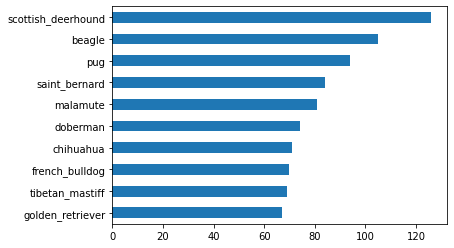

In [14]:
#check the distribution of images according to classes of dogs
dg_breed['breed'].value_counts(ascending=True).plot(kind='barh')
plt.show()

In [15]:
#split the data for training and testing - on training set we will build the model, on test set we will check model's performance
#we will further divide the training set into valdiation and training set

train_data,test_data = train_test_split(dg_breed,test_size=0.08,stratify=dg_breed['breed'],random_state=42)

In [16]:
#divide the training data further into training and validation set
train_data,cv_data = train_test_split(train_data,test_size=0.15,stratify=train_data['breed'],random_state=42)

#print the shape of all training testing and validation data
print(f'Training shape is {train_data.shape}')
print(f'Testing shape is {test_data.shape}')
print(f'Cross Validation shape is {cv_data.shape}')

Training shape is (657, 3)
Testing shape is (68, 3)
Cross Validation shape is (116, 3)


In [17]:

def plot_distribution(data,title):
  
  ''' Function to Plot the distribution of images in training, validation and testing set'''

  count = data['breed'].value_counts(ascending=True)
  plt.title(title)
  plt.barh(count.index,count)
  plt.show()

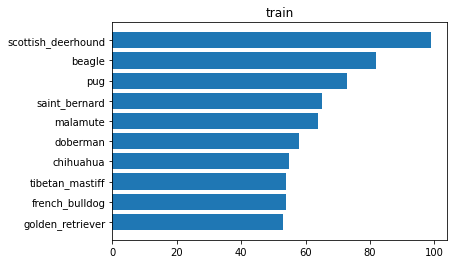

In [18]:
plot_distribution(train_data,'train')  #class distribution in training set

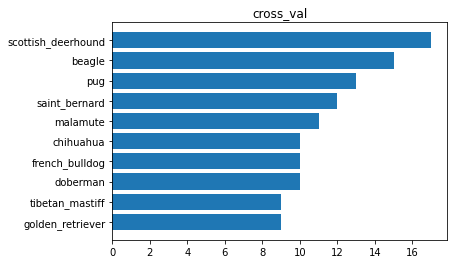

In [19]:
plot_distribution(cv_data,'cross_val')   #class distribution in validation set

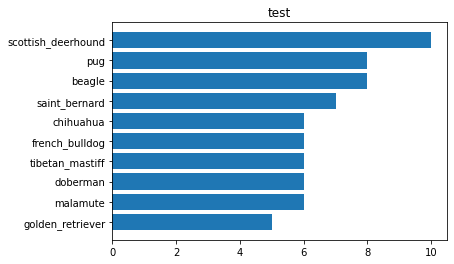

In [20]:
plot_distribution(test_data,'test')    #class distribution in testing set

In [21]:
#reset the index of training and testing and validation set to read the images
train_data.reset_index(inplace=True,drop=True)
test_data.reset_index(inplace=True,drop=True)
cv_data.reset_index(inplace=True,drop=True)

In [22]:
train_data.drop('id',inplace=True,axis=1)

In [23]:
#unique classes 

unique_breed = train_data.drop_duplicates(subset=['breed']).reset_index(drop=True)

img_width=250
img_height=250
images=[]
classes=[]

#load training images
for breed,path in tqdm(unique_breed.values):
    img = cv2.imread(path)
    classes.append(breed)
    images.append(cv2.resize(img, (img_width, img_height)))

100%|██████████| 10/10 [00:57<00:00,  5.80s/it]


In [24]:
def plot_images(images, classes):
    # Create figure with 5x2 sub-plots
    fig, axes = plt.subplots(2, 5,figsize=(12,5),sharex=True)
    fig.subplots_adjust(hspace=0.01, wspace=0.3)
   
    for i, ax in enumerate(axes.flat):
               
        ax.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB).reshape(img_width,img_height,3), cmap='hsv')    
        xlabel = "Breed: {0}".format(classes[i])
    
        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        ax.set_xticks([])
        ax.set_yticks([])
  
    plt.show()

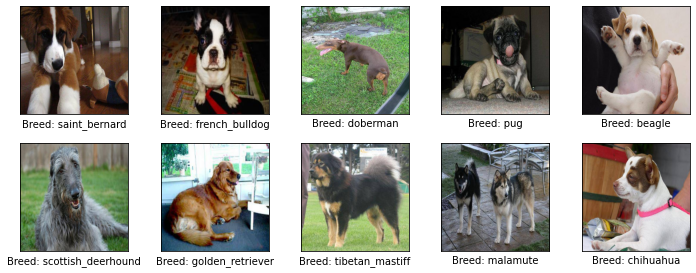

In [25]:
# show the images
images_to_show = [images[i] for i in range(0,10)]
classes_to_show = [classes[i] for i in range(0,10)]
#plot the images
plot_images(images_to_show, classes_to_show)

In [26]:
image_size = 224

def read_and_prep_images(img_paths, img_height=image_size, img_width=image_size):

    #function to load and preprocess the data

    imgs = [load_img(img_path, target_size=(img_height, img_width)) for img_path in img_paths]
    img_array = np.array([img_to_array(img) for img in imgs])
    output = preprocess_input(img_array)
    return output

In [27]:
#load and prepare training and validation images

train_paths = train_data['path'].to_list()   
cv_paths = cv_data['path'].to_list()         

train_x = read_and_prep_images(train_paths)  
cv_x = read_and_prep_images(cv_paths)        

In [28]:
#apply one hot encoding on training and cv labels

train_label= pd.get_dummies(train_data['breed'])     
cv_label = pd.get_dummies(cv_data['breed'])

In [29]:
#one hot encoded train labels
train_label.head()

,beagle,chihuahua,doberman,french_bulldog,golden_retriever,malamute,pug,saint_bernard,scottish_deerhound,tibetan_mastiff
0,0,0,0,0,0,0,0,1,0,0
1,0,0,0,1,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0
4,1,0,0,0,0,0,0,0,0,0


In [30]:
num_classes = 10

def get_model():
  # load model
  base_model = ResNet50(weights='imagenet',include_top=False)

  for layer in base_model.layers:
    layer.trainable = False

  base_model_output = base_model.output

  #adding own layers 
  x = GlobalAveragePooling2D()(base_model_output)

  #fully connected and 10 softmax 
  x = Dense(512,activation='relu')(x)
  x = Dense(num_classes,activation='softmax',name='fcnew')(x)

  model = Model(inputs=base_model.input,outputs=x)

  return model

In [31]:
#create class callbacks
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self,epoch,logs={}):
    if(logs.get('accuracy')>0.95):
      print("\n Reached 95% accuracy so cancelling training!")
      self.model.stop_training = True

callbacks = myCallback()

In [32]:
model = get_model()   #download and create instance of the model

94773248/94765736 [==============================] - 1s 0us/step


In [33]:
#compile the model
model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])

In [34]:
#check the summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 6 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [35]:
#fit the training for 15 epochs and batch size 32
hist = model.fit(train_x, train_label, epochs=15, validation_data=(cv_x, cv_label), batch_size=32,callbacks=[callbacks])

Epoch 1/15
21/21 [==============================] - 13s 178ms/step - loss: 0.5908 - accuracy: 0.1613 - val_loss: 0.2976 - val_accuracy: 0.3707
Epoch 2/15
21/21 [==============================] - 2s 108ms/step - loss: 0.2887 - accuracy: 0.3676 - val_loss: 0.2531 - val_accuracy: 0.5603
Epoch 3/15
21/21 [==============================] - 2s 108ms/step - loss: 0.2461 - accuracy: 0.5722 - val_loss: 0.2231 - val_accuracy: 0.7586
Epoch 4/15
21/21 [==============================] - 2s 109ms/step - loss: 0.2153 - accuracy: 0.7357 - val_loss: 0.2003 - val_accuracy: 0.8017
Epoch 5/15
21/21 [==============================] - 2s 109ms/step - loss: 0.1984 - accuracy: 0.8066 - val_loss: 0.1812 - val_accuracy: 0.8707
Epoch 6/15
21/21 [==============================] - 2s 109ms/step - loss: 0.1771 - accuracy: 0.8318 - val_loss: 0.1658 - val_accuracy: 0.8966
Epoch 7/15
21/21 [==============================] - 2s 109ms/step - loss: 0.1609 - accuracy: 0.8798 - val_loss: 0.1528 - val_accuracy: 0.9052
Epoch

In [38]:
# visualizing losses and accuracy with epochs 
epoch_number = [x+1 for x in range(0,13)]
train_loss = hist.history['loss']
val_loss   = hist.history['val_loss']
train_acc  = hist.history['accuracy']
val_acc    = hist.history['val_accuracy']

In [39]:
# printing a table depicting the detail about the trained model
log_frame = pd.DataFrame(columns = ["Epoch", "Train_Loss", "Train_Accuracy", "CV_Loss", "CV_Accuracy"])
log_frame["Epoch"] = epoch_number
log_frame["Train_Loss"] = train_loss
log_frame["Train_Accuracy"] = train_acc
log_frame["CV_Loss"] = val_loss
log_frame["CV_Accuracy"] = val_acc 
log_frame

,Epoch,Train_Loss,Train_Accuracy,CV_Loss,CV_Accuracy
0,1,0.449091,0.207002,0.297634,0.370690
1,2,0.280166,0.420091,0.253076,0.560345
2,3,0.242632,0.582953,0.223142,0.758621
3,4,0.214613,0.715373,0.200311,0.801724
4,5,0.192260,0.815830,0.181227,0.870690
5,6,0.173589,0.853881,0.165770,0.896552
6,7,0.158287,0.888889,0.152818,0.905172
7,8,0.145391,0.913242,0.142199,0.905172
8,9,0.134457,0.925419,0.132852,0.922414
9,10,0.125030,0.939117,0.125000,0.931035


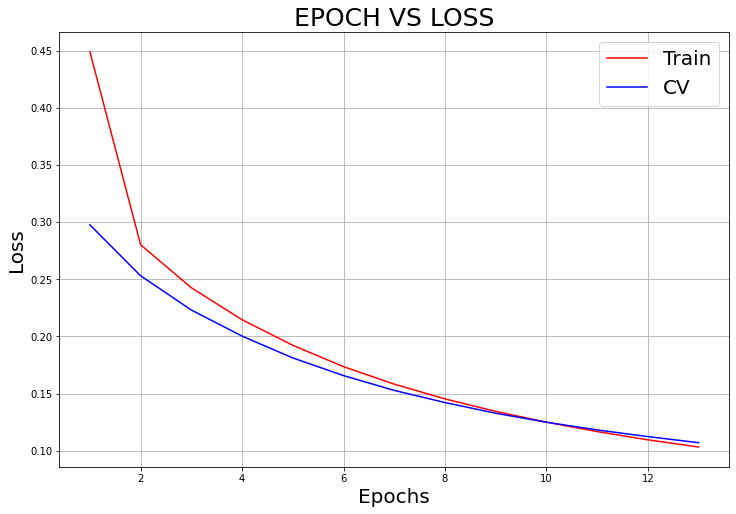

In [40]:
# plotting epoch vs loss
def plotting(epoch, train_loss, CV_loss, title):
    fig, axes = plt.subplots(1,1, figsize = (12, 8))
    axes.plot(epoch, train_loss, color = 'red', label = "Train")
    axes.plot(epoch, CV_loss, color = 'blue', label = "CV")
    axes.set_title(title, fontsize = 25)
    axes.set_xlabel("Epochs", fontsize = 20)
    axes.set_ylabel("Loss", fontsize = 20)
    axes.grid()
    axes.legend(fontsize = 20)

plotting(list(log_frame["Epoch"]), list(log_frame["Train_Loss"]), list(log_frame["CV_Loss"]), "EPOCH VS LOSS") 

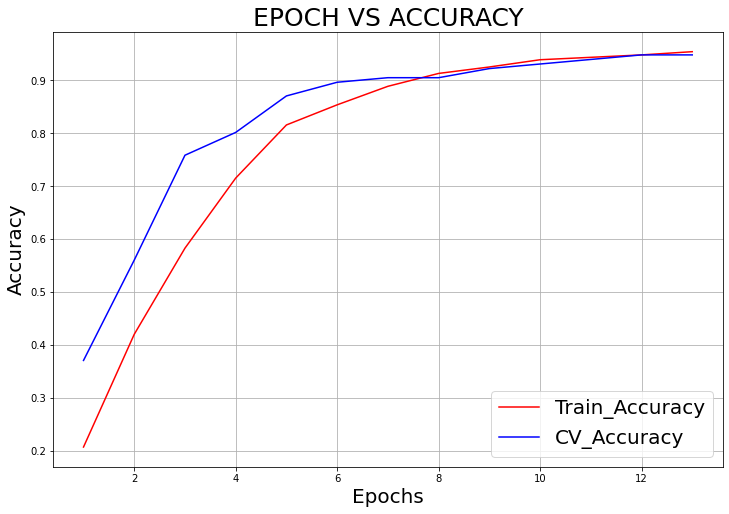

In [41]:
# plotting epoch vs accuracy
def plotting(epoch, train_acc, CV_acc, title):
    fig, axes = plt.subplots(1,1, figsize = (12, 8))
    axes.plot(epoch, train_acc, color = 'red', label = "Train_Accuracy")
    axes.plot(epoch, CV_acc, color = 'blue', label = "CV_Accuracy")
    axes.set_title(title, fontsize = 25)
    axes.set_xlabel("Epochs", fontsize = 20)
    axes.set_ylabel("Accuracy", fontsize = 20)
    axes.grid()
    axes.legend(fontsize = 20)

plotting(list(log_frame["Epoch"]), list(log_frame["Train_Accuracy"]), list(log_frame["CV_Accuracy"]), "EPOCH VS ACCURACY") 

In [ ]:
# the model does a wonderful job with accuracy of 95 on training and accuracy of 91 on validation data
# now let's prepare the testing data and see how model works on testing set

In [ ]:
test_data.drop('path',axis=1,inplace=True)  #drop the path

In [42]:
#loading testing images
test_path = list(test_data['path'])
test_img = read_and_prep_images(test_path)

In [ ]:
#map the labels

test_data['actual_labels'] = test_data['breed'].map({'beagle':0,
                                                      'chihuahua' : 1,
                                                      'doberman' : 2,
                                                      'french_bulldog' : 3,
                                                      'golden_retriever' : 4,
                                                      'malamute' : 5,
                                                      'pug' : 6,
                                                      'saint_bernard' : 7,
                                                      'scottish_deerhound' : 8,
                                                      'tibetan_mastiff' : 9})

In [45]:
#predict on test data
model.predict(test_img)

array([[1.00585455e-02, 5.09613454e-02, 3.94885615e-03, 6.01584539e-02,
        1.44917769e-02, 2.19875090e-02, 7.33457923e-01, 8.45162272e-02,
        1.10083120e-02, 9.41104162e-03],
       [9.38481152e-01, 2.30805390e-02, 3.89495748e-03, 1.44152679e-02,
        4.82014334e-03, 5.39488485e-03, 5.36840409e-03, 2.35255784e-03,
        5.52769459e-04, 1.63929013e-03],
       [3.42944544e-03, 1.75357074e-03, 8.49577773e-04, 5.59402397e-04,
        6.84899790e-03, 9.37183620e-04, 1.44865364e-03, 9.72878397e-01,
        1.35607249e-03, 9.93876345e-03],
       [5.13702333e-02, 1.57093965e-02, 1.98837789e-03, 5.31384489e-03,
        3.80812213e-02, 3.51229161e-02, 2.50724945e-02, 8.03967953e-01,
        1.96446478e-03, 2.14089695e-02],
       [9.39326584e-01, 1.77313052e-02, 1.10590560e-02, 4.91862418e-03,
        7.44632632e-03, 1.66786765e-03, 6.90471195e-03, 3.98226222e-03,
        4.21324978e-03, 2.75004539e-03],
       [1.27952710e-01, 7.00179813e-03, 4.83414233e-01, 5.18064667e-03,
   

In [46]:
#model will predict score for each label let's label with max score
test_pred = []
for i in range(len(test_img)):

  img1 = test_img[i]
  pred = np.argmax(model.predict(img1.reshape(-1,224,224,3)))
  test_pred.append(pred)

In [ ]:
#store the predicted labels in new column in test_data
test_data['prediction_labels'] = test_pred

In [47]:
classes = list(pd.get_dummies(test_data['breed']).columns)  #get the classes

In [52]:
cm = confusion_matrix(test_data['actual_labels'],test_data['prediction_labels'])

In [53]:
import itertools
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

Confusion matrix, without normalization
[[ 8  0  0  0  0  0  0  0  0  0]
 [ 0  5  0  0  1  0  0  0  0  0]
 [ 0  0  6  0  0  0  0  0  0  0]
 [ 0  0  0  6  0  0  0  0  0  0]
 [ 0  0  0  0  4  0  0  0  1  0]
 [ 0  0  0  0  0  6  0  0  0  0]
 [ 0  0  0  0  0  0  8  0  0  0]
 [ 0  0  0  0  0  0  0  7  0  0]
 [ 0  0  0  0  0  0  0  0 10  0]
 [ 0  0  0  0  0  0  1  0  0  5]]


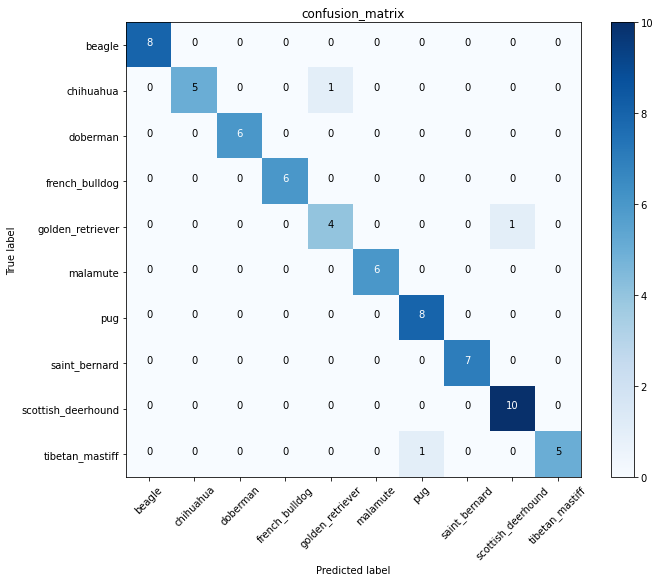

In [54]:
plt.figure(figsize=(10,8))
plot_confusion_matrix(cm=cm,classes=classes,title='confusion_matrix')

In [55]:
#build a classification report to check f1-score, precision and recall
print(classification_report(test_data['actual_labels'],
                            test_data['prediction_labels'],
                            target_names=classes))

                    precision    recall  f1-score   support

            beagle       1.00      1.00      1.00         8
         chihuahua       1.00      0.83      0.91         6
          doberman       1.00      1.00      1.00         6
    french_bulldog       1.00      1.00      1.00         6
  golden_retriever       0.80      0.80      0.80         5
          malamute       1.00      1.00      1.00         6
               pug       0.89      1.00      0.94         8
     saint_bernard       1.00      1.00      1.00         7
scottish_deerhound       0.91      1.00      0.95        10
   tibetan_mastiff       1.00      0.83      0.91         6

          accuracy                           0.96        68
         macro avg       0.96      0.95      0.95        68
      weighted avg       0.96      0.96      0.96        68



In [ ]:
roc_auc_score(test_data['actual_labels'].values,y_)

In [56]:
class_list = list(enumerate(pd.get_dummies(test_data['breed']).columns))
class_list

[(0, 'beagle'),
 (1, 'chihuahua'),
 (2, 'doberman'),
 (3, 'french_bulldog'),
 (4, 'golden_retriever'),
 (5, 'malamute'),
 (6, 'pug'),
 (7, 'saint_bernard'),
 (8, 'scottish_deerhound'),
 (9, 'tibetan_mastiff')]

In [57]:
label_dict = {}
for i,j in class_list:
  label_dict[i]=j

In [58]:
label_dict

{0: 'beagle',
 1: 'chihuahua',
 2: 'doberman',
 3: 'french_bulldog',
 4: 'golden_retriever',
 5: 'malamute',
 6: 'pug',
 7: 'saint_bernard',
 8: 'scottish_deerhound',
 9: 'tibetan_mastiff'}

In [67]:
model.save('resenetModel.h5')  #save the model

In [66]:
from tensorflow.keras.preprocessing import image
from google.colab import files
uploaded = files.upload()

for fn in uploaded.keys():
  pathh = '/content/'+fn
  img = image.load_img(pathh,target_size=(224,224))
  img_array = img_to_array(img) 
  img = np.expand_dims(img,axis=0)
  x = preprocess_input(img)
  pred_class = model.predict(x)
  print('It is a ',label_dict[np.argmax(pred_class)])
  print('-'*20)
  for i,j in enumerate(pred_class.tolist()[0]):
    print(label_dict[i],' : ',j)

Saving file_22920_doberman-pinscher.jpg to file_22920_doberman-pinscher (8).jpg
It is a  doberman
--------------------
beagle  :  0.008171089924871922
chihuahua  :  0.030921828001737595
doberman  :  0.912665605545044
french_bulldog  :  0.014054028317332268
golden_retriever  :  0.009655650705099106
malamute  :  0.0014917117077857256
pug  :  0.004344009328633547
saint_bernard  :  0.006236089393496513
scottish_deerhound  :  0.009092825464904308
tibetan_mastiff  :  0.003367149271070957


In [ ]:
#the data is limited and we have built a very good model on it
#for further improvements we can use augumentation, we can also train the complete weights of resent50, or try with some other models